In [1]:
import math
import numpy as np
import torch
import pkbar
from unet3d.config import *
from utils.Visualization import ImageSliceViewer3D
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import glob
from torch.optim import Adam
from unet3d.dataset import SAIADDataset
from torch.utils.data import DataLoader
from patchify import patchify
from utils.Other import get_headers
import nrrd
from unet3d.transforms import train_transform, val_transform

%load_ext autoreload
%autoreload 2
%matplotlib inline
_,_,patient_names = get_headers(DATASET_PATH)
device = 'cuda'


In [2]:
from unet3d.dataset import WrappedDataLoader, to_device


excl_patients_training = ['SAIAD 15', 'SAIAD 11'] #patients for validation/testing
excl_patients_val = list(set(patient_names) - set(excl_patients_training))

print("Training with val patients:", excl_patients_training)



## Load dataset ##
train_dataset = SAIADDataset(
    excl_patients=excl_patients_training,
    load_data_to_memory=True,
    n_batches=TRAIN_BATCHES_PER_EPOCH,
    transform=train_transform,
    )
val_dataset = SAIADDataset(
    excl_patients=excl_patients_val,
    load_data_to_memory=True,
    n_batches=VAL_BATCHES_PER_EPOCH,
    transform=val_transform,

)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False, 
    pin_memory=False, 
    num_workers=NUM_WORKERS
    )
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=VAL_BATCH_SIZE,
    shuffle=False, 
    pin_memory=False, 
    num_workers=NUM_WORKERS
    )

train_dataloader = WrappedDataLoader(train_dataloader, to_device, device)

Training with val patients: ['SAIAD 15', 'SAIAD 11']
Fetching patients probabilities...


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Fetching patients probabilities...


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]
/Work/Users/acharneca/.conda/envs/saiad-pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
for epoch in tqdm(range(EPOCHS)):
    for X_batch, y_batch in train_dataloader:
        break
    break


  0%|                                                                                           | 0/250 [00:19<?, ?it/s]


Loading w/ transforms: 29s/epoch

Loading w/o transforms: 27/epoch

In [4]:
[y_batch.shape, y_batch.dtype, y_batch.device]

[(8, 5, 128, 128, 128), torch.float32, device(type='cuda', index=0)]

In [5]:
n=0
x_arr = np.array(X_batch.cpu()[n,0])
y_arr = np.array(torch.argmax(y_batch.cpu()[n], dim=0))
ImageSliceViewer3D(x_arr,y_arr) #, np.array(torch.argmax(y_batch.cpu()[0], dim=0)))

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

[0 1 2 3 4]


(array([1.92944e+05, 5.58229e+05, 7.14350e+04, 2.41720e+04, 2.32770e+04,
        9.75500e+03, 3.45300e+03, 1.03600e+03, 3.53000e+02, 8.20000e+01]),
 array([-1.3995337 , -0.44333282,  0.5128681 ,  1.469069  ,  2.42527   ,
         3.381471  ,  4.3376718 ,  5.293873  ,  6.250074  ,  7.2062745 ,
         8.162476  ], dtype=float32),
 <BarContainer object of 10 artists>)

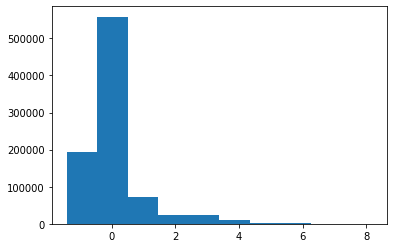

In [16]:
import matplotlib.pyplot as plt
print(np.unique(y_arr))
plt.hist(x_arr.flatten())

In [16]:
from monai.transforms import Compose, RandFlipd, ToTensord, RandGaussianNoised, RandAdjustContrastd
patchs = {'name': 'patches', 'patch_scan': X_batch[0], 'patch_segm': y_batch[0]}
transform = Compose(
    [   
        RandFlipd(keys=['patch_scan', 'patch_segm'], prob=1, spatial_axis=0),
        RandGaussianNoised(keys=['patch_scan', 'patch_segm'], prob=1, mean=0.0, std=0.1),
        RandAdjustContrastd(keys=['patch_scan', 'patch_segm'], prob=1, gamma=(0.5,2)),
    ]
)
trans_patchs = transform(patchs)
print([trans_patchs['patch_scan'].shape, trans_patchs['patch_scan'].device])
ImageSliceViewer3D(trans_patchs['patch_scan'][0].cpu().detach().numpy(), X_batch[0,0].cpu().detach().numpy())

[(1, 128, 128, 128), device(type='cuda', index=0)]


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [23]:
patch_scan.max()

tensor(255.)

In [5]:
scan, _ = nrrd.read(DATASET_PATH+'SAIAD 1/scan.nrrd')
scan = torch.Tensor(scan)
pad_x=(100,100)
pad_y=(200,200)
pad_z=(50,50)
print(pad_x + pad_y + pad_z)
print(scan.shape)
scan_pad = torch.nn.functional.pad(scan, pad_x + pad_y + pad_z, 'constant', 0)
print(scan_pad.shape)
ImageSliceViewer3D(np.array(scan), np.array(scan_pad))                 

(100, 100, 200, 200, 50, 50)
torch.Size([512, 512, 128])
torch.Size([612, 912, 328])


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [7]:
np.min(scan)

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
